## No man's land - Are these "proteins" actually multiple isoforms due to alternative splicing with different localisations?

Here, we will explore whether the lack of classification is in part due to some peptides originating from multiple isoforms with different localisations. To test this we will use ribo-seq(1) data to define the proteins which have multiple expressed isoforms in mouse embryonic stem cells. We will then look for enrichment of these proteins in the "unclassified" proteins. e.g No Man's Land / Non-machine Learnable (NML) 

### Technical details:
A major assumption in this analysis is that the peptides used to estimate protein expression can not differentiate between different protein isoforms. In the cases where this is definitely not the case, e.g where the hyperLOPIT data includes more than one row with the same protein id but different isoforms, the hyperLOPIT data is excluded from the analysis. However, a more detailed analysis starting from the peptide is required to determine which peptides are actually unique to one or another of the protein isoforms which may be present. 

Another assumption is that the ribo-seq data accurately captures the full repetoire of protein isoforms.

In order to identify the protein isoforms, a number of heuristic decision have to be made:
* Minimal expression level of an isoform. This is set at 0.1 FPKM
* How "mixed" does the expression profile of a protein need to be between the isoforms to be considerd as multi-isoform. Here, any protein with less then 90% expression from the major isoform is considered to have multiple isoforms

The ribo-seq transcripts also include a small number of transcript ids with suffixes, e.g ".1". The expression values are summed across all the unique transcript ids, i.e having removed suffixes, on the assmpution that these transcripts are the same protein isoform.


We exclude the following from the analysis:
* Ribo-seq transcripts which map to multiple protein ids(!) -> 8 transcripts
* Ribo-seq genes where no transcripts map to a uniprot id -> 5928 genes
* Ribo-seq genes where the consituent transcripts map to multiple protein uniprot ids(!) -> 12 proteins
* LOPIT Proteins with multiple isoforms in hyperLOPIT data (as explained above) -> 21 proteins
* LOPIT Proteins where there is no ribo-seq data -> 285 proteins

--> In total, of the 5011/5032 retained hyperLOPIT proteins, we have ribos-seq data for 4726 proteins, of which 913 have multiple isoforms.


### Executive summary:
    
There is a slight enrichment for proteins with multiple isoforms in the unclassified proteins. A protein with multiple isoforms is ~1.4 times more likely to be unclassified than a protein without multiple isoforms. Approximately 7% of the unclassified proteins may be unclassified because of this. 

For a more detailed summary see the 'Conclusions and Discussion' section at the end of the notebook



(1)
"Embryonic stem cells exhibit mRNA isoform-specific translational regulation"
Wong QW, Vaz C, Lee QY, Zhao TY, Luo R, Archer SK, Preiss T, Tanavde V, Vardy LA
GSE73467

In [3]:
import pandas as pd
import numpy as np
import os
import collections

wkdir = "/Users/toms/WT/NML"
data_dir = os.path.join(wkdir, "data")

First we need to convert the ncbi ids in the ribo-seq data to uniprot ids. I've tried multiple ways to convert from ncbi transcript/gene id to uniprot id and all give different answers! The most sensible approach appears to be to use the uniprot website converter tool.

Below, we have the dataframe from the uniprot website coversion using all ncbi transcript ids in the ribo-seq data:

In [316]:
uniprot_df = pd.read_table(os.path.join(data_dir, "uniprot_convert.tsv"), sep="\t", index_col=0)
uniprot_df.index.name = "ncbi_id"
uniprot_df = uniprot_df[uniprot_df['Status']=="reviewed"]
print uniprot_df.head(2)
print uniprot_df.shape

t_id_counts = collections.Counter(uniprot_df.index)

print uniprot_df.ix['NM_145412']

             isomap:M20161122AAFB7E4D2F1D05654627429E83DA5CCE998041Y   Entry  \
ncbi_id                                                                        
NM_001001152                                                NaN       Q6P5C7   
NM_001001160                                                NaN       Q6NS60   

               Entry name    Status            Protein names  \
ncbi_id                                                        
NM_001001152  ZN728_MOUSE  reviewed  Zinc finger protein 728   
NM_001001160  FBX41_MOUSE  reviewed    F-box only protein 41   

                              Gene names              Organism  Length  
ncbi_id                                                                 
NM_001001152               Znf728 Zfp458  Mus musculus (Mouse)     752  
NM_001001160  Fbxo41 D6Ertd538e Kiaa1940  Mus musculus (Mouse)     873  
(15093, 8)
          isomap:M20161122AAFB7E4D2F1D05654627429E83DA5CCE998041Y   Entry  \
ncbi_id                                   

Ok, so there are 8 transcript ids (or sets of transcript ids) which map to multiple proteins. This is only a small number so let's just ignore these to make things simplier.

In [67]:
n = 0
for t_id in uniprot_df.index:
    if t_id_counts[t_id]>1:
        n+=1
        print t_id, t_id_counts[t_id]   
print n
    

NM_001164787,NM_011468 2
NM_001164787,NM_011468 2
NM_001031664,NM_021431 2
NM_001031664,NM_021431 2
NM_001270495,NM_001270498,NM_026679 2
NM_001270495,NM_001270498,NM_026679 2
NM_145412 2
NM_145412 2
8


In [68]:
t_id2uniprot = {}
t_id2length = {}

for t_id in uniprot_df.index:
    if t_id_counts[t_id]>1:
        continue
    for t_split_id in t_id.split(","):
        t_id2uniprot[t_split_id] = uniprot_df.ix[t_id]['Entry']
        t_id2length[t_split_id] = uniprot_df.ix[t_id]['Length'] 
        
    

We now have a dictionary to convert ncbi id to uniprot id. We will use this later to annotate the ribo-seq data.

In [69]:
print t_id2uniprot['NM_001114098']

Q3UHU5


In [8]:
scaled_df = pd.read_table(os.path.join(data_dir, "GSE73467_Scaled_data.csv"), sep=",")
scaled_df = scaled_df.iloc[:,0:6]
print scaled_df.head(2)

ribo_gene2transcript = {}
ribo_gene2uniprot = {}
ribo_gene2length = {}
uniprot_ids = []
scaled_df.set_index("Gene", inplace=True, drop=True)

counter = collections.Counter()

for ribo_gene in set(scaled_df.index):
    transcripts = scaled_df.ix[ribo_gene]['Transcript']
   
    if type(transcripts) == str:
        ribo_gene2transcript[ribo_gene] = [transcripts]
        if transcripts in t_id2uniprot:
            counter['single transcript'] += 1
            ribo_gene2uniprot[ribo_gene] = t_id2uniprot[transcripts]
            ribo_gene2length[ribo_gene] = t_id2length[transcripts]
        else:
            counter["no matches for single transcript, setting to 'NA'"] += 1
            ribo_gene2uniprot[ribo_gene] = "NA"
            ribo_gene2length[ribo_gene] = "NA"
    else:
        transcripts = transcripts.tolist()
        ribo_gene2transcript[ribo_gene] = transcripts
        
        possible_uniprot_ids = set()
        possible_lengths = set()
        for transcript in transcripts:
            if transcript in t_id2uniprot:
                possible_uniprot_ids.add(t_id2uniprot[transcript])
                possible_lengths.add(t_id2length[transcript])
        if len(possible_uniprot_ids) == 0:
            counter["no matches for any transcript, setting to 'NA'"] += 1
            ribo_gene2uniprot[ribo_gene] = "NA"
            ribo_gene2length[ribo_gene] = "NA"
        else:
            if len(possible_uniprot_ids)>1:
                counter["more than one possible uniprot id, setting to 'NA'"] += 1
                ribo_gene2uniprot[ribo_gene] = "NA"
                ribo_gene2length[ribo_gene] = "NA"
            else:
                counter['multiple transcript'] += 1
                ribo_gene2uniprot[ribo_gene] = list(possible_uniprot_ids)[0]
                ribo_gene2length[ribo_gene] = list(possible_lengths)[0]


print counter
print len(uniprot_ids)
print scaled_df.shape

  Transcript           Gene  Scaled bc05 (E1)  Scaled bc06 (E2)  \
0  NR_038165  0610005C13Rik          0.074308          0.088382   
1  NR_038166  0610005C13Rik          0.000003          0.000003   

   Scaled bc07 (E3)  Scaled bc08 (E4)  
0               0.0               0.0  
1               0.0               0.0  
Counter({'single transcript': 11786, "no matches for single transcript, setting to 'NA'": 5239, 'multiple transcript': 3349, "no matches for any transcript, setting to 'NA'": 689, "more than one possible uniprot id, setting to 'NA'": 12})
0
(27796, 5)


Some of the transcript ids have a e.g '.1' suffix. We only want unique ids so we'll extract the unique id, group on this and sum the expression values

In [9]:
#print scaled_df.head()
scaled_df['unique_Transcript'] = [x.split(".")[0] for x in scaled_df['Transcript']]
agg_dict = {}
for col in scaled_df.reset_index().columns:
    if col == "Transcript" or col == "unique_Transcript":
        pass
    elif col == "Gene" or col == "uniprot_id":
        agg_dict[col] = lambda x: list(x)[0]
    else:
        agg_dict[col] = np.sum

unique_scaled_df = scaled_df.reset_index().groupby('unique_Transcript').agg(agg_dict)

unique_scaled_df = unique_scaled_df.reset_index().set_index("Gene")

print unique_scaled_df.columns
print unique_scaled_df.head(2)

Index([u'unique_Transcript', u'Scaled bc05 (E1)', u'Scaled bc08 (E4)',
       u'Scaled bc07 (E3)', u'Scaled bc06 (E2)'],
      dtype='object')
          unique_Transcript  Scaled bc05 (E1)  Scaled bc08 (E4)  \
Gene                                                              
Zfp85-rs1      NM_001001130          0.367869          0.852209   
Scap           NM_001001144          0.205486          0.341253   

           Scaled bc07 (E3)  Scaled bc06 (E2)  
Gene                                           
Zfp85-rs1          5.812045          2.753571  
Scap               1.749569          3.307144  


Quick check tghat the ids match up...

In [10]:
print unique_scaled_df.shape
print scaled_df.shape
print len(set(scaled_df['unique_Transcript']))
s_i = set(scaled_df.index)
u_s_i = set(unique_scaled_df.index)

print len(s_i.difference(u_s_i))
print len(u_s_i.difference(s_i))



(27411, 5)
(27796, 6)
27411
0
0


In [11]:
def getMaxFraction(array):
    '''get the minimum fold difference between the largest
    and remaining elements from list
    
    return np.nan if all elements are zero or the list is length 1'''
    a_max = max(array)
    
    if a_max == 0:
        return np.nan
    
    return float(a_max)/sum(array)

print getMaxFraction([0,1,2,3,19,2,10])
print float(19)/sum([0,1,2,3,19,2,10])

0.513513513514
0.513513513514


In [12]:
def getMinFoldDifference(array, min_expression_threshold):
    '''get the minimum fold difference between the largest
    and remaining elements from list
    
    return np.nan if all elements are zero or the list is length 1'''
    a_max = max(array)
    
    thresholded_array = [x for x in array if x > min_expression_threshold]
    
    if a_max == 0 or len(thresholded_array) < 2:
        return np.nan
    
    try:
        difference = float(sorted(thresholded_array, reverse=True)[1])/a_max
    except:
        print thresholded_array
        raise ValueError
    return difference

print getMinFoldDifference([0,1,2,3,19,2,10], 3)
print 10.0/19

print getMinFoldDifference([0,1,2,3,19,2,10], 10)


0.526315789474
0.526315789474
nan


In the following few cells, we annotate the ribo-seq data with the mean expression, expression difference between isoforms, # of isoforms and fraction accounted for by major isoform

In [13]:
mean_expression = unique_scaled_df.apply(lambda x: np.mean(x[1:5]), axis=1)
unique_scaled_df['mean_expression'] = mean_expression

In [171]:
min_expression_threshold = 0.1

min_difference = unique_scaled_df.reset_index().groupby("Gene")['mean_expression'].apply(
    lambda x: getMinFoldDifference(x, min_expression_threshold))
unique_scaled_df['min_difference'] = min_difference 

In [172]:
max_fraction = unique_scaled_df.reset_index().groupby("Gene")['mean_expression'].apply(
    lambda x: getMaxFraction(x))
unique_scaled_df['max_fraction'] = max_fraction

In [173]:
isoforms = unique_scaled_df.reset_index().groupby("Gene")['mean_expression'].apply(
    lambda x: len([y for y in x if y > min_expression_threshold]))
unique_scaled_df['isoforms'] = isoforms

Let's see how many proteins are identified using the thresholds given here...

In [174]:
difference_threshold = 0.1
expression_threshold = 0.1
fraction_threshold = 0.9

min_difference_thresholded = min_difference[min_difference > difference_threshold]
mean_expression_thresholded = mean_expression[mean_expression > expression_threshold]
max_fraction_thresholded = max_fraction[max_fraction < fraction_threshold]

print len(min_difference_thresholded)
print len(min_difference)

print len(mean_expression_thresholded)
print len(mean_expression)

print len(max_fraction_thresholded)
print len(max_fraction)

2323
21075
18890
27411
2973
21075


In [175]:
print unique_scaled_df.shape

print mean_expression_thresholded.index
thresholded_scaled_df = unique_scaled_df[unique_scaled_df['mean_expression'] > 0]
print thresholded_scaled_df.shape

thresholded_scaled_df = thresholded_scaled_df[thresholded_scaled_df ['min_difference'] > difference_threshold]
print thresholded_scaled_df.shape

thresholded_scaled_df = thresholded_scaled_df[thresholded_scaled_df ['max_fraction'] < fraction_threshold]
print thresholded_scaled_df.shape

(27411, 9)
Index([u'Zfp85-rs1', u'Scap', u'Zfp458', u'Fbxo41', u'Taf9b', u'Zfp941',
       u'BC031181', u'Baz2b', u'Ccdc111', u'BC048507',
       ...
       u'Fuk', u'Gpr19', u'4732471J01Rik', u'Ube2w', u'Adck5', u'Flcn',
       u'Nol8', u'Nol8', u'Gnb5', u'Chka'],
      dtype='object', name=u'Gene', length=18890)
(26210, 9)
(6341, 9)
(6285, 9)


In [176]:
print unique_scaled_df.ix['0610007P08Rik']

              unique_Transcript  Scaled bc05 (E1)  Scaled bc08 (E4)  \
Gene                                                                  
0610007P08Rik      NM_001013608          1.409492          8.711642   
0610007P08Rik         NM_023507          0.065154          0.044201   

               Scaled bc07 (E3)  Scaled bc06 (E2)  mean_expression  \
Gene                                                                 
0610007P08Rik         37.552596         21.642879        17.329152   
0610007P08Rik          0.213406          0.606047         0.232202   

               min_difference  max_fraction  isoforms  
Gene                                                   
0610007P08Rik        0.013399      0.986778         2  
0610007P08Rik        0.013399      0.986778         2  


In [177]:
annotation_df = unique_scaled_df[['min_difference', 'mean_expression', 'max_fraction', 'isoforms']].reset_index(
    ).groupby('Gene').agg({'min_difference':np.mean, 'mean_expression':sum,
                           'max_fraction':np.mean, 'isoforms':np.mean})

annotation_df['uniprot_id'] = [ribo_gene2uniprot[x] for x in annotation_df.index]
annotation_df['length'] = [ribo_gene2length[x] for x in annotation_df.index]
print annotation_df.head()
print annotation_df.shape

print annotation_df.sort_values('isoforms').tail(10)
print annotation_df.sort_values('isoforms').head(10)

               isoforms  max_fraction  min_difference  mean_expression  \
Gene                                                                     
0610005C13Rik         0      0.999963             NaN         0.040674   
0610007N19Rik         1      1.000000             NaN         0.350836   
0610007P08Rik         2      0.986778        0.013399        17.561354   
0610007P14Rik         1      1.000000             NaN        36.144407   
0610007P22Rik         2      0.698118        0.432422        23.216892   

              uniprot_id length  
Gene                             
0610005C13Rik         NA     NA  
0610007N19Rik         NA     NA  
0610007P08Rik     Q9JIM3   1537  
0610007P14Rik     Q9ERY9    140  
0610007P22Rik     Q5HZH2    323  
(21075, 6)
          isoforms  max_fraction  min_difference  mean_expression uniprot_id  \
Gene                                                                           
Ubap2l           8      0.247555        0.729089        40.507876     Q8

Now we need to annotate the hyperLOPIT data with the mean expression, min_difference, max_fraction and isoforms.

In [178]:
lopit_df = pd.read_table(os.path.join(data_dir, "ncomms.tsv.txt"), sep="\t")

lopit_df['uniprot_id'] = [x.split("-")[0] for x in lopit_df['UniProt Accession for Protein Group']]
print len(lopit_df['uniprot_id'])
print lopit_df.shape

lopit_df.drop_duplicates(subset=['uniprot_id'], inplace=True)
print lopit_df.shape

5032
(5032, 46)
(5011, 46)


Frequency tables and then a Fisher's exact test

In [245]:
print lopit_df.shape
merged_df = pd.merge(lopit_df, annotation_df, left_on="uniprot_id", right_on="uniprot_id", how="inner")
print merged_df.shape

merged_df = merged_df[merged_df['isoforms']>0]
merged_df['classified'] = merged_df['Final Localization Assignment'] != "unclassified"
merged_df['low_fraction'] = merged_df['max_fraction'] < 0.9
merged_df['AS'] = ((merged_df['isoforms'] > 1) &
                   (merged_df['max_fraction'] < 0.9) &
                   (merged_df['min_difference'] > 0.1))
print pd.crosstab(merged_df.isoforms, [merged_df['classified'], merged_df['low_fraction']])
print pd.crosstab(merged_df['Final Localization Assignment'], merged_df['AS'])
print pd.crosstab(merged_df['classified'], merged_df['AS'])

merged_df.columns = [x.replace(" ", "_") for x in merged_df.columns]

(5011, 46)
(4726, 51)
classified   False       True       
low_fraction False True  False True 
isoforms                            
1             1469     2  2122     2
2               70   282    95   257
3                6   123     9   111
4                1    48     3    42
5                0    24     0    16
6                0     6     0     8
7                0     3     0     0
8                0     2     0     0
9                0     2     0     1
10               0     0     0     1
AS                                     False  True 
Final Localization Assignment                      
40S Ribosome                              39      5
60S Ribosome                              52      8
Actin cytoskeleton                        33     10
Cytosol                                  299     35
Endoplasmic reticulum/Golgi apparatus    356     59
Endosome                                  40     16
Endosome                                   2      0
Extracellular matrix         

In [180]:
import scipy.stats
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [181]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

In [182]:
print merged_df.columns

Index([u'UniProt_Accession_for_Protein_Group', u'UniProt_ID_for_Protein_Group',
       u'UniProt_Protein_Description', u'Quantified_Peptides_Experiment_1',
       u'Quantified_Peptides_Experiment_1.1',
       u'Quantified_PSMs_(Rep_1)_Experiment_1',
       u'Quantified_PSMs_(Rep_1)_Experiment_1.1', u'126', u'127N', u'127C',
       u'128N', u'128C', u'129N', u'129C', u'130N', u'130C', u'131', u'126.1',
       u'127N.1', u'127C.1', u'128N.1', u'128C.1', u'129N.1', u'129C.1',
       u'130N.1', u'130C.1', u'131.1', u'phenoDisco_Input',
       u'phenoDisco_Output', u'Curated_phenoDisco_Output', u'SVM_marker_set',
       u'SVM_classification', u'SVM_score',
       u'SVM_classification_(top_quartile)', u'Final_Localization_Assignment',
       u'First_localization_evidence?', u'Curated_Organelles',
       u'Cytoskeletal_Components', u'Trafficking_Proteins',
       u'Protein_Complexes', u'Signaling_Cascades', u'Oct4_Interactome',
       u'Nanog_Interactome', u'Sox2_Interactome', u'Cell_Surface_

In [258]:
odds, p = scipy.stats.fisher_exact(pd.crosstab(merged_df['classified'], merged_df['AS']))

print "odds ratio: %f, p.value: %f" % (1/odds, p)
odds_ratios = []
p_values = []

#print sum([x!=y for x, y in zip(merged_df['SVM_classification_(top_quartile)'],
#                                merged_df['Final_Localization_Assignment'])])

#thresholded = merged_df['Final_Localization_Assignment'].tolist()
#top_quartile = merged_df['SVM_classification_(top_quartile)'].tolist()

#assert len(thresholded)==len(top_quartile)

#for ix in xrange(0, len(thresholded)):
    #if thresholded[ix]!=top_quartile[ix] and thresholded[ix].replace(" ", "")!=top_quartile[ix].replace(" ", ""):
        #if thresholded[ix]!="unclassified" and top_quartile[ix]!='unclassified':
        #print merged_df.iloc[ix,:]
        #break

for group in set(merged_df['Final_Localization_Assignment']):
    #print "\n", group
    merged_df['temp_binary'] = merged_df['Final_Localization_Assignment'] == group
    odds, p = scipy.stats.fisher_exact(pd.crosstab(merged_df['temp_binary'], merged_df['AS']))
    odds_ratios.append(odds)
    p_values.append(p)
    #print "odds ratio: %f, p.value: %f" % (odds, p)
    
fishers_df = pd.DataFrame({'odds': odds_ratios, 'p-values':p_values},
                          index=set(merged_df['Final_Localization_Assignment']))

fishers_df['fdr'] = stats.p_adjust(FloatVector(fishers_df['p-values']), method = 'BH')
fishers_df['sig'] = fishers_df['fdr'] <0.1

print pd.crosstab(merged_df['Final_Localization_Assignment'], merged_df['AS'])

print fishers_df


odds ratio: 1.624790, p.value: 0.000000
AS                                     False  True 
Final_Localization_Assignment                      
40S Ribosome                              39      5
60S Ribosome                              52      8
Actin cytoskeleton                        33     10
Cytosol                                  299     35
Endoplasmic reticulum/Golgi apparatus    356     59
Endosome                                  40     16
Endosome                                   2      0
Extracellular matrix                      13      1
Lysosome                                  63     10
Mitochondrion                            491     64
Nucleus - Chromatin                      226     63
Nucleus - Chromatin                        2      1
Nucleus - Non-chromatin                  309     66
Peroxisome                                21      4
Plasma membrane                          261     85
Proteasome                                31      2
unclassified            

So, according to a naive Fisher's exact test using thresholds to determine whether a protein exists in multiple isoforms, there is a slight enrichment for multiple isoform proteins in the "unclassified" group.

Next, we'll perform a logisitic regression using the dependent value = "unclassified" and the independent values "max_fraction", "isoforms" and "min_difference"

In [184]:
merged_df = pd.DataFrame(merged_df)


merged_df.to_csv(os.path.join(wkdir, "notebooks/results/annotated_stem_cell_hyperlopit.tsv"), sep="\t", index=False)


In [185]:
%%R -i wkdir

merged_df = read.table(paste0(wkdir, "/notebooks/results/annotated_stem_cell_hyperlopit.tsv"),
                       sep="\t", header=T)


The plots below show the relationships between expression, length, AS and P(classification).

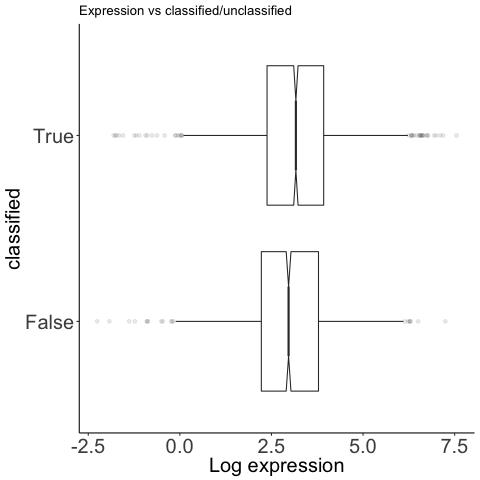

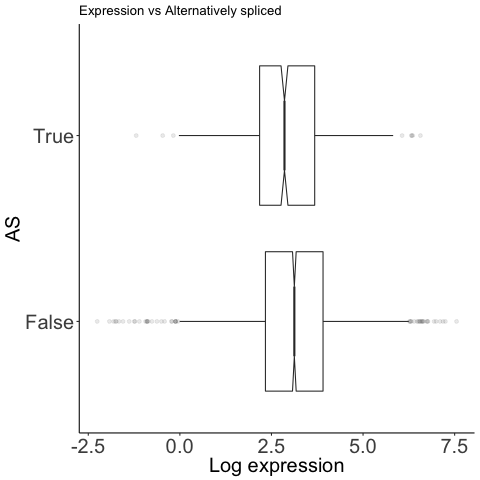

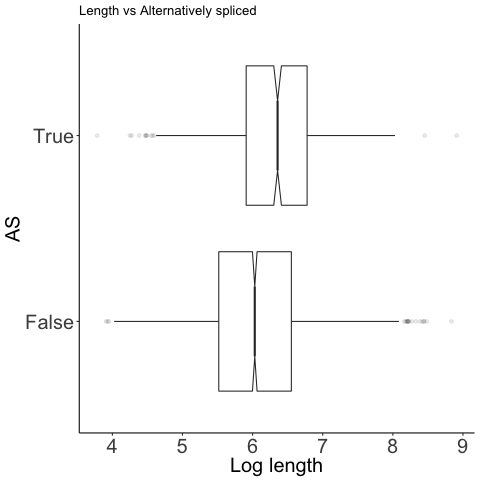

In [199]:
%%R
library(ggplot2)

mytheme = theme(axis.text=element_text(size=20), axis.title=element_text(size=20))

p = ggplot(merged_df, aes(classified, log(mean_expression))) + coord_flip() + ylab("Log expression") + 
geom_boxplot(alpha=0.1, notch=T) + theme_classic() + mytheme + ggtitle ("Expression vs classified/unclassified")
print(p)


p = ggplot(merged_df, aes(AS, log(mean_expression))) + coord_flip() + ylab("Log expression") + 
geom_boxplot(alpha=0.1, notch=T) + theme_classic() + mytheme + ggtitle ("Expression vs Alternatively spliced")
print(p)

p = ggplot(merged_df, aes(AS, log(length))) + coord_flip() + ylab("Log length") + 
geom_boxplot(alpha=0.1, notch=T) + theme_classic() + mytheme + ggtitle ("Length vs Alternatively spliced")
print(p)

A more sophisticated approach - logistic regression

In [301]:
%%R
print(dim(merged_df))

merged_df$log_mean_expression = log(merged_df$mean_expression)

model <- glm(classified ~ AS + log_mean_expression + length, family=binomial(link='logit'), data=merged_df)
print(summary(model))

model <- glm(classified ~ max_fraction + log_mean_expression + length,
             family=binomial(link='logit'), data=merged_df)
print(summary(model))

AS_rows_binary = NULL
AS_rows_continuous = NULL

for (class in unique(merged_df$Final_Localization_Assignment)){
    merged_df$tmp_binary <- merged_df$Final_Localization_Assignment == class
    model_binary <- glm(tmp_binary ~ AS + log_mean_expression + length,
                        family=binomial(link='logit'), data=merged_df)
    AS_rows_binary[class] <- list(coef(summary(model_binary))[2,])
    
    model_continuous <- glm(tmp_binary ~ max_fraction + log_mean_expression + length,
                            family=binomial(link='logit'), data=merged_df)
    AS_rows_continuous[class] <- list(coef(summary(model_continuous))[2,])
}

getLogitDF <- function(rows){
    logit_df = as.data.frame(do.call(rbind, rows))
    logit_df$FDR <- p.adjust(logit_df[['Pr(>|z|)']], method="BH")
    logit_df$sig <- logit_df$FDR < 0.05
    logit_df$odds_ratio = round(exp(logit_df$Estimate), 3)
    logit_df$odds_ci_low = round(exp(logit_df$Estimate - (1.96*logit_df[['Std. Error']])), 3)
    logit_df$odds_ci_high = round(exp(logit_df$Estimate + (1.96*logit_df[['Std. Error']])), 3)
    return(logit_df)
}

logit_df_binary = getLogitDF(AS_rows_binary)
logit_df_continuous = getLogitDF(AS_rows_continuous)

print(logit_df_binary)

print(logit_df_continuous)

[1] 3119   59

Call:
glm(formula = classified ~ AS + log_mean_expression + length, 
    family = binomial(link = "logit"), data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4633  -1.2523   0.9844   1.0802   1.6274  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          1.386e-01  1.139e-01   1.217 0.223730    
ASTrue              -3.601e-01  9.015e-02  -3.994 6.49e-05 ***
log_mean_expression  8.392e-02  2.952e-02   2.843 0.004469 ** 
length              -2.556e-04  7.092e-05  -3.604 0.000313 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4301.6  on 3118  degrees of freedom
Residual deviance: 4254.4  on 3115  degrees of freedom
AIC: 4262.4

Number of Fisher Scoring iterations: 4


Call:
glm(formula = classified ~ max_fraction + log_mean_expression + 
    length, family = binomial(link = "logit"), data = 

## CONCLUSIONS AND DISCUSSION:

### A naive Fisher's exact test to look for enrichment of proteins with multiple isoforms in the unclassified proteins:

A statistically significant (FDR = 1.143e-09) 1.62-fold enrichment is observed for proteins with multiple isoforms in the unclassified proteins. Note that applying the same test across all classifications also yields a depletion for cytosolic, mitochondrial or ER/golgi and enrichment for PM.

However, this naive analysis does not consider other protein characteristic which might be driving the probability of classification and confounded with the probability of having multiple isoforms. For a more sophisiticate approach, see the section below using logistic regression.

In [262]:

print pd.crosstab(merged_df['classified'], merged_df['AS'])
print "\nUnclassified odds ratio: %f, FDR: %0.12f" % tuple(fishers_df.ix['unclassified'][[0,1]].tolist())
print '\nComplete results for all classifications:\n', fishers_df

AS          False  True 
classified              
False        1554    484
True         2238    429

Unclassified odds ratio: 1.624790, FDR: 0.000000000067

Complete results for all classifications:
                                           odds      p-values           fdr  \
Endosome                               1.673133  8.895637e-02  2.160369e-01   
Extracellular matrix                   0.318742  4.941484e-01  6.000373e-01   
Cytosol                                0.465694  7.443563e-06  4.218019e-05   
Nucleus - Chromatin                    1.169485  2.831178e-01  4.813002e-01   
Lysosome                               0.655487  2.361690e-01  4.690642e-01   
60S Ribosome                           0.635784  3.226290e-01  4.986084e-01   
40S Ribosome                           0.529905  2.483281e-01  4.690642e-01   
unclassified                           1.624790  6.724011e-11  1.143082e-09   
Nucleus - Non-chromatin                0.878326  3.768804e-01  5.339139e-01   
Endoplasmic

### Using logistic regression to look for enrichment of proteins with multiple isoforms in the unclassified proteins:

Here, we use a generalised linear model (logistic regression) to look for a signficant effect from having multiple isoforms (a binary variable) on the probability of a protein being unclassified. This allows us to include additional continuous covariates of protein expression and length which may also contribute to the probability of being unclassified and might both be confouned with the probability of having multiple isoforms. Thus, if we do not account for these, we might identify erroneous enrichment for multiple isoform proteins simply because they have a different expression or length profile than single isoform proteins. 

We can see in the first table below, "binary isoform variable", that even when including these covariates, multiple isoforms still has a significant impact of on the probability of being unclassified or classified as cytosolic. The effects on the other classifications is not observed with this analysis. Thus, it appears that the unclassified proteins are slightly enriched for proteins with multiple isoforms.

Using the logistic regression, we can estimate the percentage of the unclassified proteins which are unclassified because they have multiple isoforms. We do this by imagining all proteins had only a single isoform and all other covariates remain fixed. In this case, the number of proteins that would have been unclassified if it were not for their multiple isoforms is estimated by 1-(1/odds ratio) * (unclassified & multiple isoforms) =

(1-(1/1.4)) * 484  = 138.28 (95% CI = 80.7 - 199.3) out of 2038 = ~7% +- 3%.

Note that the above assumes that we have identified all the proteins with multiple isoforms. 

The other advantage of the logistic regression approach is that we do not have to categorise the proteins into the binary groups "multiple isoforms" and "single isoform". Rather we can use the protein characteristic used to determine this binary variable. For example, we calculate the maximum proportion of a proteins expression which is accounted for by the most abundant isoform. Where this is below 90%, we consider the protein to have multiple isoforms (other filters are also used but this is the most important). We would also expect that as the fraction of expression of the most abundant isoform decreases, the probability of being unclassified should increase. We can test this by using the continuous variable "max_fraction" in the logistic regression.

The table below, "continuous isoform variable", demonstrates that the continuous variable (fraction of expression from the major isoform) significantly effects the probability of a protein being unclassified. Note that the coefficients are in the opposite direction since a lower "max fraction" gives a higher probability of having multiple isoforms. This confirms the previous analysis that having multiple isoforms has a signficiant impact of the probability of being unclassified.

So, on the one hand, the lack of classification may be partly due to peptides originating from multiple isoforms with difference localisations. On the other hand, the influence of multiple isoforms is only slight (logistic regression odds ratio 1.4, CI 1.2-1.7 giving ~7% of non classification events due to multiple isoforms)


In [219]:
%%R
print("Binary isoform variable")
print(logit_df_binary)

print("Continuous isoform variable")
print(logit_df_continuous)

[1] "Binary isoform variable"
                                          Estimate   Std. Error      z value
unclassified                            0.36006813 9.014875e-02  3.994155475
Nucleus - Chromatin                     0.16933913 1.749778e-01  0.967774822
Actin cytoskeleton                      0.14487852 5.132459e-01  0.282278976
Endoplasmic reticulum/Golgi apparatus  -0.35250829 1.799288e-01 -1.959154609
Mitochondrion                          -0.37386116 1.718804e-01 -2.175123355
Nucleus - Non-chromatin                -0.11895357 1.784177e-01 -0.666713792
Extracellular matrix                   -1.24086003 1.115401e+00 -1.112479138
Plasma membrane                         0.36093204 1.599738e-01  2.256194947
Cytosol                                -0.62934746 2.153285e-01 -2.922731232
Endosome                                0.25495395 3.707300e-01  0.687707909
60S Ribosome                            0.08685635 5.040303e-01  0.172323659
Lysosome                               -0.7232